Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [115]:
import pathlib                           # importing all necessary packages
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import random
import glob
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [116]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [117]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
Train_path='/content/gdrive/MyDrive/CNN assignment/Train'
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN assignment/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/CNN assignment/Test")

In [118]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)                                                # checking the size of train and test datasets.

2239
127


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [119]:
batch_size = 32
img_height = 180                 # providing new size of images for rescaling.
img_width = 180
input_shape=(img_height, img_width, 3)

Use 80% of the images for training, and 20% for validation.

In [120]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split=0.2,subset="training",seed=123,image_size=(img_height, img_width),batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [121]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds =  tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split=0.2,subset="validation",seed=123,image_size=(img_height, img_width),batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [122]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

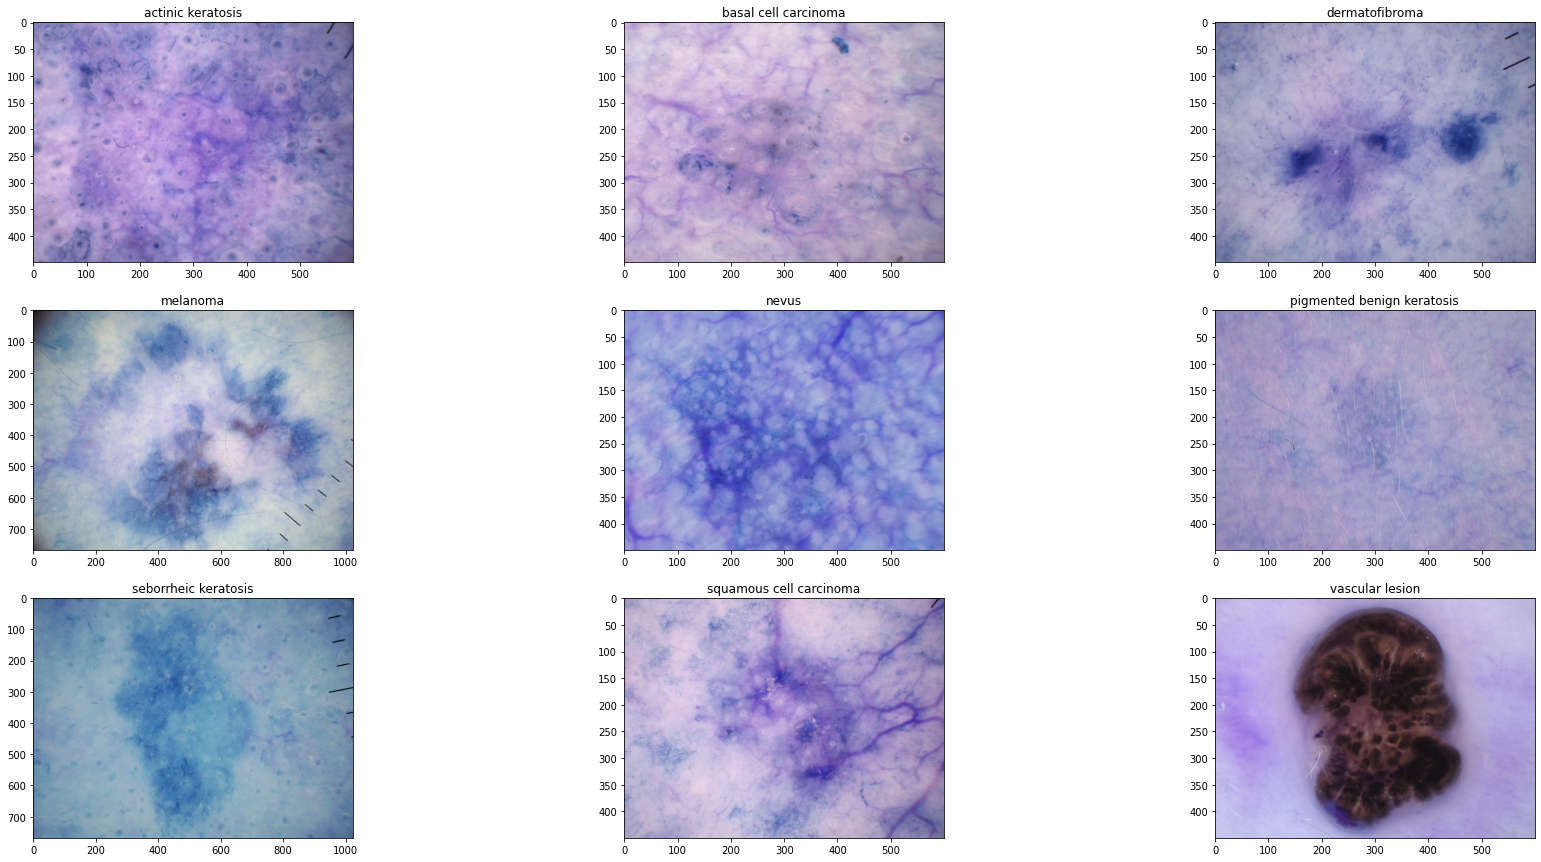

In [123]:
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize = (30,15))
for num,i in enumerate(class_names):
    plt.subplot(3,3,num+1)
    x = (glob.glob(f'{Train_path}/{i}/*.jpg'))
    im = cv2.imread(random.choice(x))
    plt.title(i)
    plt.imshow(im)
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [124]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [125]:
### Your code goes here
### rescaling the pixels and creating a sequential neural network
model=Sequential(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# First convo layer
model.add(Conv2D(32, kernel_size=(3, 3),padding='same',activation='relu',input_shape=(img_height, img_width, 3)))

# First maxpooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convo layer
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu'))

# Second maxpooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convo layer
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu'))

# Third maxpooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and use a Fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))

# Output layer or Softmax Layer
model.add(Dense(len(class_names), activation='softmax'))

# Summary of the model
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 88, 88, 32)        9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 44, 44, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 42, 42, 32)        9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 21, 21, 32)      

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [126]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [127]:
epochs = 25
history = model.fit(train_ds,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=val_ds,
              shuffle=True)

Epoch 1/25
56/56 [==============================] - 18s 85ms/step - loss: 2.1780 - accuracy: 0.1949 - val_loss: 1.9941 - val_accuracy: 0.2506
Epoch 2/25
56/56 [==============================] - 1s 23ms/step - loss: 1.9712 - accuracy: 0.2620 - val_loss: 1.8940 - val_accuracy: 0.3087
Epoch 3/25
56/56 [==============================] - 1s 22ms/step - loss: 1.7969 - accuracy: 0.3434 - val_loss: 1.9092 - val_accuracy: 0.3579
Epoch 4/25
56/56 [==============================] - 1s 23ms/step - loss: 1.6087 - accuracy: 0.4517 - val_loss: 1.5033 - val_accuracy: 0.4631
Epoch 5/25
56/56 [==============================] - 1s 23ms/step - loss: 1.4095 - accuracy: 0.4936 - val_loss: 1.6016 - val_accuracy: 0.4832
Epoch 6/25
56/56 [==============================] - 1s 22ms/step - loss: 1.4053 - accuracy: 0.5170 - val_loss: 1.4903 - val_accuracy: 0.4787
Epoch 7/25
56/56 [==============================] - 1s 23ms/step - loss: 1.3056 - accuracy: 0.5317 - val_loss: 1.4307 - val_accuracy: 0.4989
Epoch 8/25
5

### Visualizing training results

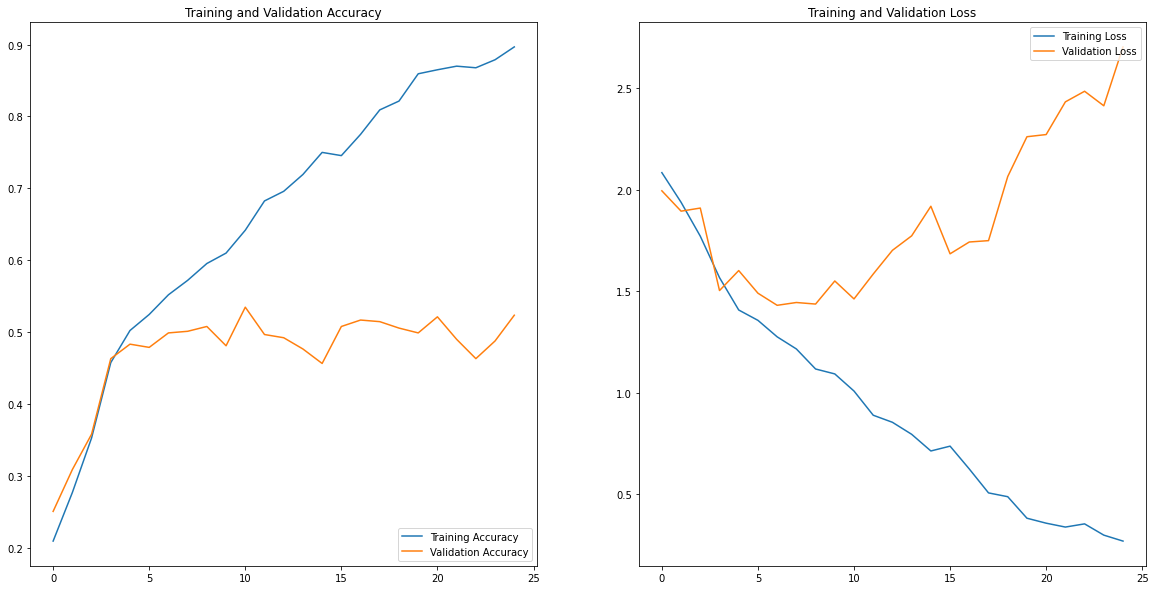

In [128]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [129]:
### We can see that training set accuracy is way more than validation set accuracy which indicates Overfitting.

In [130]:
### We can use augmentation methods such as 
# 1.Image shifts via the width_shift_range and height_shift_range arguments.
# 2.Image flips via the horizontal_flip and vertical_flip arguments.
# 3.Image rotations via the rotation_range argument
# 4.Image brightness via the brightness_range argument.
# 5.Image zoom via the zoom_range argument.

# Your code goes here
data_aug = keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.2,seed = 123),
    layers.experimental.preprocessing.RandomContrast(0.25,seed = 123),
    layers.experimental.preprocessing.RandomFlip(mode = 'horizontal_and_vertical',input_shape=input_shape,seed = 123),
    layers.experimental.preprocessing.RandomZoom(0.2,seed = 123)])


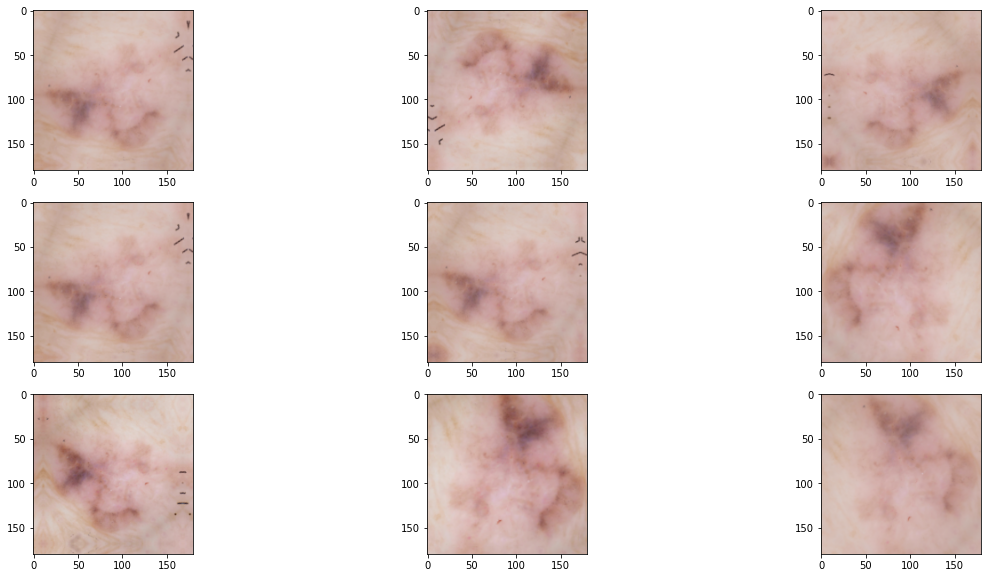

In [131]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(20, 10))
for img, _ in train_ds.take(1):
  for i in range(len(class_names)):
    aug_img = data_aug(img)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(aug_img[0].numpy().astype('int'))

### Todo:
### Create the model, compile and train the model


In [132]:
### Your code goes here
### rescaling the pixels and creating a sequential neural network
model=Sequential([data_aug,layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3))])

# First convo layer
model.add(Conv2D(32, kernel_size=(3, 3),padding='same',activation='relu',input_shape=(img_height, img_width, 3)))

# First maxpooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Second convo layer
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu'))

# Second maxpooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Third convo layer
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu'))

# Third maxpooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Flatten and use a Fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# Output layer or Softmax Layer
model.add(Dense(len(class_names), activation='softmax'))


### Compiling the model

In [133]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [134]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(train_ds,batch_size=batch_size,epochs=epochs,validation_data=val_ds,shuffle=True)

Epoch 1/25
56/56 [==============================] - 3s 36ms/step - loss: 2.1419 - accuracy: 0.1827 - val_loss: 2.0137 - val_accuracy: 0.3065
Epoch 2/25
56/56 [==============================] - 2s 33ms/step - loss: 1.8693 - accuracy: 0.3390 - val_loss: 1.7366 - val_accuracy: 0.4295
Epoch 3/25
56/56 [==============================] - 2s 33ms/step - loss: 1.7230 - accuracy: 0.3749 - val_loss: 1.6644 - val_accuracy: 0.4228
Epoch 4/25
56/56 [==============================] - 2s 33ms/step - loss: 1.6447 - accuracy: 0.4096 - val_loss: 1.6102 - val_accuracy: 0.4631
Epoch 5/25
56/56 [==============================] - 2s 33ms/step - loss: 1.5940 - accuracy: 0.4269 - val_loss: 1.6525 - val_accuracy: 0.4474
Epoch 6/25
56/56 [==============================] - 2s 33ms/step - loss: 1.5792 - accuracy: 0.4472 - val_loss: 1.5217 - val_accuracy: 0.4922
Epoch 7/25
56/56 [==============================] - 2s 33ms/step - loss: 1.5475 - accuracy: 0.4662 - val_loss: 1.4818 - val_accuracy: 0.5168
Epoch 8/25
56

### Visualizing the results

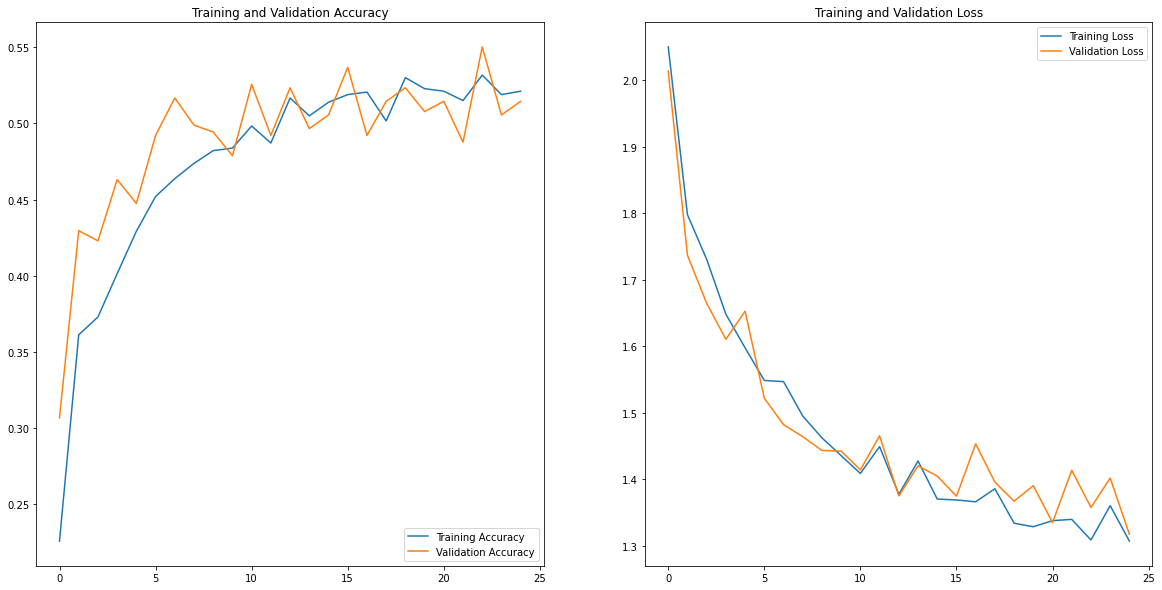

In [135]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

We can see that accuracy of training set and validation set are approximately same so there is no overfitting but since the accuracy values are low we can say there is underfitting present in the model.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [136]:
## Your code goes here.

## We can use dictionary with class names as keys and their counts as values.
dict={}
for num,i in enumerate(class_names):
  dict[i]=len(glob.glob(f'{Train_path}/{i}/*.jpg')) 
dict

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

In [137]:
sorted(dict.items(), key =  lambda kv:(kv[1], kv[0]))

[('seborrheic keratosis', 77),
 ('dermatofibroma', 95),
 ('actinic keratosis', 114),
 ('vascular lesion', 139),
 ('squamous cell carcinoma', 181),
 ('nevus', 357),
 ('basal cell carcinoma', 376),
 ('melanoma', 438),
 ('pigmented benign keratosis', 462)]

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


1. The class Seborrheic Keratosis has the least number of samples(77).

2. The class pigmented benign keratosis dominates the data in terms proportionate number of Samples(462).

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [138]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [139]:
path_to_training_dataset=Train_path
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset,i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE7C409D810>: 100%|██████████| 500/500 [00:18<00:00, 26.89 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE7BA3167D0>: 100%|██████████| 500/500 [00:18<00:00, 27.62 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE7BA3645D0>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE7BB69A850>: 100%|██████████| 500/500 [00:18<00:00, 26.48 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE7BA368F90>: 100%|██████████| 500/500 [01:22<00:00,  6.03 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN assignment/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=962x671 at 0x7FE8260461D0>: 100%|██████████| 500/500 [01:23<00:00,  6.01 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN assignment/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE7BB152410>: 100%|██████████| 500/500 [00:19<00:00, 26.07 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE7BB22D0D0>: 100%|██████████| 500/500 [00:41<00:00, 12.19 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE7C7E70F90>:   0%|          | 1/500 [00:00<01:16,  6.55 Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE7BB3B7B10>: 100%|██████████| 500/500 [00:19<00:00, 26.15 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE824D1FFD0>: 100%|██████████| 500/500 [00:18<00:00, 26.34 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [140]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [141]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN assignment/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010872.jpg_1714a24c-658b-4ca5-9f3d-3568906d0225.jpg',
 '/content/gdrive/MyDrive/CNN assignment/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011125.jpg_6e606bf1-d7fc-42ff-856a-f7349165e5f0.jpg',
 '/content/gdrive/MyDrive/CNN assignment/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011128.jpg_eccd355a-f4bf-4e39-88ca-2d9238919ad4.jpg',
 '/content/gdrive/MyDrive/CNN assignment/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011135.jpg_c2b262f0-2fe7-43a3-863f-a016b6fde1f8.jpg',
 '/content/gdrive/MyDrive/CNN assignment/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010942.jpg_23359590-1d6b-445a-966e-d8866ced5f7f.jpg',
 '/content/gdrive/MyDrive/CNN assignment/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010863.jpg_91b91f27-a5e4-4ca1-8f0a-edd42e643d50.jpg',
 '/content

In [142]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [143]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [144]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [145]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [146]:
## your code goes here
### Your code goes here
### rescaling the pixels and creating a sequential neural network
model=Sequential([data_aug,layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3))])

# First convo layer
model.add(Conv2D(32, kernel_size=(3, 3),padding='same',activation='relu',input_shape=(img_height, img_width, 3)))

# First maxpooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convo layer
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))

# Second maxpooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))


# Flatten and use a Fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))

# Output layer or Softmax Layer
model.add(Dense(len(class_names), activation='softmax'))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [147]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history =  model.fit(train_ds,batch_size=batch_size,epochs=epochs,validation_data=val_ds,shuffle=True)

Epoch 1/30
169/169 [==============================] - 44s 247ms/step - loss: 2.9127 - accuracy: 0.1902 - val_loss: 1.7959 - val_accuracy: 0.3400
Epoch 2/30
169/169 [==============================] - 42s 242ms/step - loss: 1.6962 - accuracy: 0.3539 - val_loss: 1.5180 - val_accuracy: 0.4536
Epoch 3/30
169/169 [==============================] - 42s 243ms/step - loss: 1.5909 - accuracy: 0.3934 - val_loss: 1.4256 - val_accuracy: 0.4640
Epoch 4/30
169/169 [==============================] - 42s 244ms/step - loss: 1.5173 - accuracy: 0.4318 - val_loss: 1.3907 - val_accuracy: 0.4803
Epoch 5/30
 95/169 [===============>..............] - ETA: 15s - loss: 1.3978 - accuracy: 0.4676

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Class rebalance helped in increasing accuracy of the model so that model does not underfit and since there is no much difference between accuracy of training and validation set our model is not overfitting.